# Training Word2Vec model








In [1]:
!pip install underthesea 
# common
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# languages
from underthesea import word_tokenize

#Modeling packages

# Word2vec
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors


In [4]:
# import data
df_new=pd.read_csv('../data/raw/dwell_reviews/dwell_review_1.csv')


In [5]:
df_new['comment'].head(20)

0    The access to the wifi service was not easy to...
1    There was a bit of confusion when we were abou...
2    Reception was a bit confusing. We arrived for ...
3    There was no dish washing liquid or cloths to ...
4    Booking was made online but rang and spoke wit...
5    There are no comments available for this revie...
6    There are no comments available for this revie...
7    There are no comments available for this revie...
8    There are no comments available for this revie...
Name: comment, dtype: object

In [6]:
# WORD2VEC 
W2V_SIZE = 400
W2V_WINDOW = 10 # max distance bt the current and predicted
W2V_EPOCH = 35 
W2V_MIN_COUNT = 5 # Ignore word frequence < n
SEED = 567 # random


In [7]:
# Word2Vec model using Bag of word
w2v_model = Word2Vec(seed=SEED, 
                        vector_size=W2V_SIZE,
                        window=W2V_WINDOW,
                        min_count=W2V_MIN_COUNT
                        )

In [18]:
documents = [_text.split() for _text in df_new.comment.astype(str)]


In [19]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
w2v_model.build_vocab(tqdm(documents))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 76.9 ms


(862, 15855)

In [49]:
w2v_model.wv.most_similar(positive='great',topn=20)

KeyError: "Key 'great' not present"

In [25]:
w2v_model.save("w2v.model")

# Sentence2vec




In [37]:
import re
import numpy as np
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from underthesea import word_tokenize


In [38]:
# Sentence2vec based on Word2Vec 
class Sentence2Vec:
    def __init__(self, model_file):
        self.load(model_file)

    def load(self, model_file):
        self.model = Word2Vec.load(model_file)

    def get_vector(self, sentence):
        vectors = [self.model.wv[w] for w in word_tokenize(sentence)
                   if w in self.model.wv]

        v = np.zeros(self.model.vector_size)

        if (len(vectors) > 0):
            v = (np.array([sum(x) for x in zip(*vectors)])) / v.size
        return v

    def similarity(self, x, y):
        xv = self.get_vector(x)
        yv = self.get_vector(y)

        score = 0

        if xv.size > 0 and yv.size > 0:
            score = dot(xv, yv) / (norm(xv) * norm(yv))

        return score


In [39]:
model = Sentence2Vec('w2v.model')

In [40]:
matrix = np.zeros((len(documents),W2V_SIZE))
for i in range(len(documents)):
        matrix[i] = model.get_vector(str(documents[i]))
print(matrix.shape)

(9, 400)


# PCA to reduce dimention (40D)




In [41]:
from sklearn.decomposition import PCA

# fit a 40d PCA model to the vectors
pca = PCA(n_components=80)
PCA_result = pca.fit_transform(matrix)
print(PCA_result.shape)

ValueError: n_components=80 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'

# K-mean clustering

In [42]:
iteration = 20
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=iteration,normalise= True ,avoid_empty_clusters= True)
assigned_clusters = kclusterer.cluster(PCA_result, assign_clusters=True)


NameError: name 'PCA_result' is not defined

In [43]:
assigned_clusters = np.array(assigned_clusters)

NameError: name 'assigned_clusters' is not defined

# **Result**

In [44]:
pca = PCA(n_components=2)
PCA_new = pca.fit_transform(matrix)

In [45]:
d = {'document' : df_new["comment"], 'label':assigned_clusters, 'x': PCA_new[:,0], 'y': PCA_new[:,1]}
df = pd.DataFrame(data=d)

NameError: name 'assigned_clusters' is not defined

In [46]:
#filter rows of original data
filtered_label0 = df[assigned_clusters == 0]
filtered_label1 = df[assigned_clusters == 1]
filtered_label2 = df[assigned_clusters == 2]


NameError: name 'df' is not defined

In [47]:
filtered_label0.head(60)

NameError: name 'filtered_label0' is not defined

In [34]:
filtered_label1.head(50)

NameError: name 'filtered_label1' is not defined

In [35]:
filtered_label2.head(50)

NameError: name 'filtered_label2' is not defined

NameError: name 'filtered_label0' is not defined

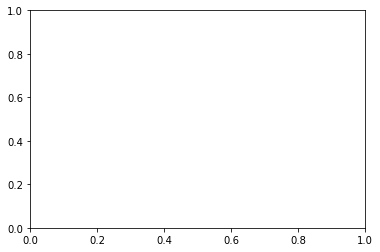

In [36]:
#Plotting the results
fig, ax = plt.subplots()
scatter0= plt.scatter(filtered_label0['x'] , filtered_label0['y'] , color = 'red')
scatter1 = plt.scatter(filtered_label1['x'] , filtered_label1['y'] , color = 'green')
scatter2 = plt.scatter(filtered_label2['x'] , filtered_label2['y'] , color = 'blue')
ax.legend([scatter0, scatter1, scatter2], ['Negative', 'Neutral', 'Positive'])

plt.show()
